# Implementation of Anomaly detection using Autoencoders
Dataset used here is Credit Card Fraud Detection from Kaggle.

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,normalize, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
# Load layers from keras
from keras.layers import Dense, Concatenate, Input, Reshape, Flatten, BatchNormalization, Dropout, LeakyReLU
from keras.models import Model
from keras.losses import binary_crossentropy
from Disco_tensor_flow import distance_corr
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
RANDOM_SEED = 2021 
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
##########################################################
# ------------------------------------------------------ #
# ----------------------- LOADING ---------------------- #
# ------------------------------------------------------ #
##########################################################
# Firstly the model loads the background and signal data, 
# then it removes the attributes first string line, which 
# are the column names, in order to avoid NaN values in 
# the array.

print('         ==== Commencing Initiation ====\n')

### Background
b_name='/home/thiago/Documents/Data_Sets/LPC-anomaly-detection/Input_Background_1.csv'
background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
print("     .Background Loaded..." )
print("     .Background shape: {}".format(background.shape))

### Signal
s_name='/home/thiago/Documents/Data_Sets/LPC-anomaly-detection/Input_Signal_1.csv'
signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
print("     .Signal Loaded...")
print("     .Signal shape: {}\n".format(signal.shape))

         ==== Commencing Initiation ====

     .Background Loaded...
     .Background shape: (543500, 21)
     .Signal Loaded...
     .Signal shape: (522467, 21)



In [47]:
##########################################################
# ------------------------------------------------------ #
# --------------------- INITIATION --------------------- #
# ------------------------------------------------------ #
##########################################################

# Number of events
total = 100000

# Percentage of background samples on the testing phase
background_percent = 0.99

# Percentage of samples on the training phase
test_size = 0.3

In [48]:
print('\n          ==== Initiation Complete ====\n')
print('=*='*17 )
print('\n      ==== Commencing Pre-processing ====\n')

# Percentage of background samples to divide the data-set
dat_set_percent = total/len(background)

# Reducing background samples
_,reduced_background = train_test_split(background, test_size=dat_set_percent)

# Deviding train and test background

train_data, background_test = train_test_split(reduced_background, test_size=test_size)

# Iserting the correct number of signal in streaming

n_signal_samples = int(len(background_test)*(1-background_percent))

_,background_test = train_test_split(background_test, test_size=background_percent)

_,signal_test = train_test_split(signal, test_size=n_signal_samples/len(signal))

# Concatenating Signal and the Background sub-sets

test_data = np.vstack((background_test,signal_test))

# Normalize Data

print('.Normalizing Data')

test_data = normalize(test_data,
                        norm='max',
                        axis=0
                    )

train_data = normalize(train_data,
                        norm='max',
                        axis=0
                    )

# Creates test data frame

attributes = np.array(["px1",
                        "py1",
                        "pz1",
                        "E1",
                        "eta1",
                        "phi1",
                        "pt1",
                        "px2",
                        "py2",
                        "pz2",
                        "E2",
                        "eta2",
                        "phi2",
                        "pt2",
                        "Delta_R",
                        "M12",
                        "MET",
                        "S",
                        "C",
                        "HT",
                        "A"]
                    )

test_df = pd.DataFrame(test_data,columns = attributes)

# Creating Labels
print('.Creating Labels')

test_labels =np.ones((len(test_data)))
test_labels[:len(background_test)] = 0

print('\n      ==== Pre-processing Complete ====\n')
print(".Train data shape: {}".format(train_data.shape))
print(".Test data shape: {}".format(test_data.shape))
print(".Test Background shape: {}".format(background_test.shape))
print(".Test Signal shape: {}".format(signal_test.shape))

print('=*='*17 )


          ==== Initiation Complete ====

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=

      ==== Commencing Pre-processing ====

.Normalizing Data
.Creating Labels

      ==== Pre-processing Complete ====

.Train data shape: (70000, 21)
.Test data shape: (30000, 21)
.Test Background shape: (29700, 21)
.Test Signal shape: (300, 21)
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=


In [55]:
train_jets = train_data[:,:14]
train_colision = train_data[:,14:]

test_jets = test_data[:,:14]
test_colision = test_data[:,14:]

In [56]:
# build one block for each dense layer
def get_block(L, size):
    L = BatchNormalization()(L)

    L = Dense(size)(L)
    L = Dropout(0.5)(L)
    L = LeakyReLU(0.2)(L)
    return L

# baseline correlation function
def binary_cross_entropy(y_true, y_pred):
    
    return binary_crossentropy(y_true, y_pred)

# define new loss with distance decorrelation
def decorr(var_1, var_2, weights,kappa):

    def loss(y_true, y_pred):
        #return binary_crossentropy(y_true, y_pred) + distance_corr(var_1, var_2, weights)
        #return distance_corr(var_1, var_2, weights)
        return binary_crossentropy(y_true, y_pred) + kappa * distance_corr(var_1, var_2, weights)
        #return binary_crossentropy(y_true, y_pred)

    return loss

In [57]:
# Setup network
# make inputs

jets = Input(shape=train_jets.shape[1])
sample_weights = Input(shape=(1,))
#setup trainable layers
d1 = get_block(jets, 8)
d2 = get_block(d1, 4)
d3 = get_block(d2, 2)
d4 = get_block(d3, 2)
d5 = get_block(d4, 4)
o = get_block(d5, 7)

model = Model(inputs=[jets, sample_weights], outputs=o)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 14)           56          input_7[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 8)            120         batch_normalization_20[0][0]     
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 8)            0           dense_20[0][0]                   
____________________________________________________________________________________________

In [58]:
# Compile model
from keras.optimizers import Adam
opt = Adam(lr=0.001)
#model.compile(optimizer=opt, loss=decorr(jets[:,0], o[:,0], sample_weights[:,0],0.5))
model.compile(optimizer=opt, loss="binary_crossentropy")

In [59]:
# Train model
history_1 = model.fit(x = [train_jets, np.ones(len(train_jets))], 
                    y = train_colision,
                    epochs=150,
                    batch_size=200,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history


Train on 63000 samples, validate on 7000 samples
Epoch 1/150
62600/63000 [============================>.] - ETA: 0s - loss: 3.3840

/home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss did not improve from 0.54864
63000/63000 [==============================] - 14s 217us/sample - loss: 3.3807 - val_loss: 2.1072
Epoch 2/150
62800/63000 [============================>.] - ETA: 0s - loss: 2.5865
Epoch 00002: val_loss did not improve from 0.54864
63000/63000 [==============================] - 12s 184us/sample - loss: 2.5862 - val_loss: 0.9244
Epoch 3/150
63000/63000 [==============================] - ETA: 0s - loss: 2.4209
Epoch 00003: val_loss did not improve from 0.54864
63000/63000 [==============================] - 11s 181us/sample - loss: 2.4209 - val_loss: 0.7477
Epoch 4/150
63000/63000 [==============================] - ETA: 0s - loss: 2.3776
Epoch 00004: val_loss did not improve from 0.54864
63000/63000 [==============================] - 12s 183us/sample - loss: 2.3776 - val_loss: 0.6130
Epoch 5/150
62600/63000 [============================>.] - ETA: 0s - loss: 2.3276
Epoch 00005: val_loss did not improve from 0.54864
63000/63000 [===========

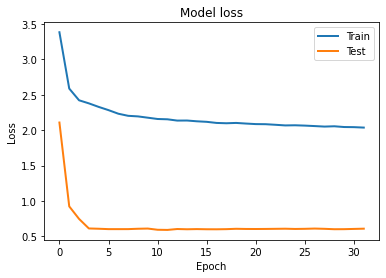

In [60]:
plt.plot(history_1['loss'], linewidth=2, label='Train')
plt.plot(history_1['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [61]:
test_x_predictions = model.predict([test_jets ,np.ones(len(test_jets))])
mse = np.mean(((test_colision - test_x_predictions)**2)**0.5,axis=1)
mse.shape

(30000,)

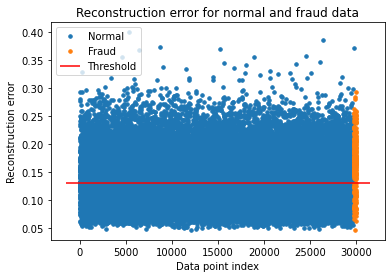

In [62]:

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})
                        
threshold_fixed = 0.13
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

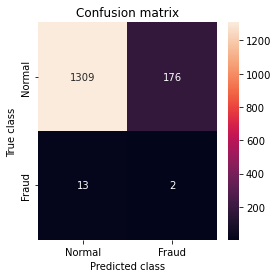

 Accuracy:  0.874
 Recall:  0.13333333333333333
 Precision:  0.011235955056179775


In [25]:
threshold_fixed =0.24
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

In [9]:
nb_epoch = 20
batch_size = 200
input_dim = train_jets.shape[1]
encoding_dim = 8
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2 = 2
learning_rate = 0.001

cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

In [49]:
#input Layer
input_layer = Input(shape=(input_dim, ))
sample_weights = Input(shape=(1, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",                                
activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='sigmoid')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='sigmoid')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='sigmoid')(decoder)
decoder = tf.keras.layers.Dense(7, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=[input_layer, sample_weights], outputs=decoder)
autoencoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 8)            120         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_99 (Dropout)            (None, 8)            0           dense_103[0][0]                  
__________________________________________________________________________________________________
dense_104 (Dense)               (None, 4)            36          dropout_99[0][0]                 
____________________________________________________________________________________________

In [50]:

opt = Adam(lr=0.001)
autoencoder.compile(optimizer=opt, loss=decorr(input_layer[:,0], decoder[:,0], sample_weights[:,0],100))


In [51]:
Train = [train_jets, np.ones(len(train_jets))]

history_2 = autoencoder.fit(x = Train, y = train_colision,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Train on 3150 samples, validate on 350 samples
Epoch 1/20
3150/3150 [==============================] - ETA: 0s - loss: 2.8231

/home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 3.84256, saving model to autoencoder_fraud.h5
3150/3150 [==============================] - 6s 2ms/sample - loss: 2.8231 - val_loss: 3.8426
Epoch 2/20
2800/3150 [=========================>....] - ETA: 0s - loss: 2.8568
Epoch 00002: val_loss improved from 3.84256 to 3.63665, saving model to autoencoder_fraud.h5
3150/3150 [==============================] - 1s 208us/sample - loss: 2.8426 - val_loss: 3.6366
Epoch 3/20
3000/3150 [===========================>..] - ETA: 0s - loss: 2.2464
Epoch 00003: val_loss did not improve from 3.63665
3150/3150 [==============================] - 0s 111us/sample - loss: 2.2461 - val_loss: 4.7664
Epoch 4/20
3000/3150 [===========================>..] - ETA: 0s - loss: 2.3429
Epoch 00004: val_loss improved from 3.63665 to 3.11048, saving model to autoencoder_fraud.h5
3150/3150 [==============================] - 1s 189us/sample - loss: 2.4111 - val_loss: 3.1105
Epoch 5/20
3000/3150 [===========================>..] - ET

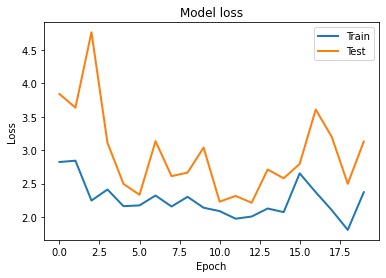

In [52]:
plt.plot(history_2['loss'], linewidth=2, label='Train')
plt.plot(history_2['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

/home/thiago/yes/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


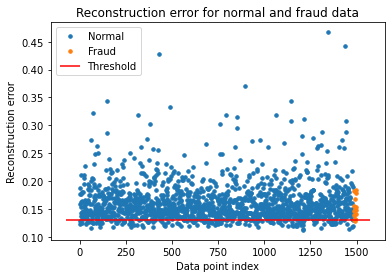

In [54]:
test_x_predictions = autoencoder.predict([test_jets ,np.ones(len(test_jets))])
mse = np.mean(np.power(test_colision - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})
                        
threshold_fixed = 0.13
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()